Epoch 1/5
853/853 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5634 - val_loss: 0.3527
Epoch 2/5
853/853 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3461 - val_loss: 0.3430
Epoch 3/5
853/853 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3409 - val_loss: 0.3414
Epoch 4/5
853/853 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3413 - val_loss: 0.3408
Epoch 5/5
853/853 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3409 - val_loss: 0.3405


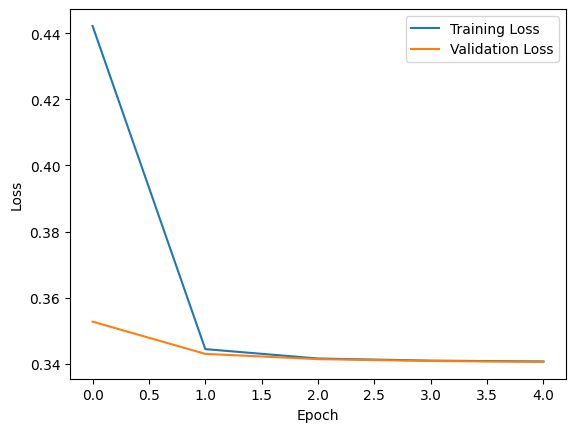

136461/136461 ━━━━━━━━━━━━━━━━━━━━ 169s 1ms/step
Detected 151213 anomalies.
                        id_x                date          user       pc  \
10  {A6N9-D5VK97CX-7245PVFQ} 2010-01-04 07:37:50  DTAA/AAA0371  PC-1689   
14  {G4P3-P7LC16EB-8242LSLL} 2010-01-05 07:51:57  DTAA/AAA0371  PC-1689   
17  {M8T0-D7PE49XC-9772FUEX} 2010-01-06 07:45:24  DTAA/AAA0371  PC-1689   
25  {N1G4-D6XO43BP-9289UKPB} 2010-01-07 07:47:03  DTAA/AAA0371  PC-1689   
63  {D3A5-P4SS66YG-1374JFSN} 2010-01-08 07:53:33  DTAA/AAA0371  PC-1689   

   activity_x  hour  after_hours  logon_count id_y activity_y  \
10      Logon   7.0          1.0        843.0    0          0   
14      Logon   7.0          1.0        843.0    0          0   
17      Logon   7.0          1.0        843.0    0          0   
25      Logon   7.0          1.0        843.0    0          0   
63      Logon   7.0          1.0        843.0    0          0   

    thumb_drive_usage  thumb_drive_count id url  url_count  role  \
10            

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

# Set GPU memory growth to avoid TensorFlow using all GPU memory upfront
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting GPU memory growth: {e}")

# Load and preprocess logon data
logon_data = pd.read_csv('/content/r1/logon.csv')
logon_data['date'] = pd.to_datetime(logon_data['date'])
logon_data['hour'] = logon_data['date'].dt.hour
logon_data['after_hours'] = logon_data['hour'].apply(lambda x: 1 if x < 8 or x > 18 else 0)  # Flag after-hours logins
logon_data['logon_count'] = logon_data.groupby('user')['user'].transform('count')  # Count logins per user

# Load and preprocess device data
device_data = pd.read_csv('/content/r1/device.csv')
device_data['date'] = pd.to_datetime(device_data['date'])
device_data['thumb_drive_usage'] = device_data['activity'].apply(lambda x: 1 if x == 'connect' else 0)
device_data['thumb_drive_count'] = device_data.groupby('user')['thumb_drive_usage'].transform('sum')  # Thumb drive usage count

# Load and preprocess HTTP data
http_data = pd.read_csv('/content/r1/http.csv', header=None, names=['id', 'date', 'user', 'pc', 'url'])
http_data['date'] = pd.to_datetime(http_data['date'])
http_data['url_count'] = http_data.groupby('user')['url'].transform('count')  # Count URLs visited per user

# Load and preprocess LDAP data
ldap_folder = '/content/r1/LDAP'
ldap_files = [os.path.join(ldap_folder, file) for file in os.listdir(ldap_folder) if file.endswith('.csv')]
ldap_data = pd.concat([pd.read_csv(file) for file in ldap_files], ignore_index=True)
ldap_data['role'] = ldap_data['Role'].apply(lambda x: 1 if x == 'IT Admin' else 0)  # Mark privileged users
ldap_data.rename(columns={'user_id': 'user'}, inplace=True)
ldap_data = ldap_data[['user', 'role']].drop_duplicates()

# Merge all datasets
merged_data = pd.merge(logon_data, device_data, on=['user', 'pc', 'date'], how='outer')
merged_data = pd.merge(merged_data, http_data, on=['user', 'pc', 'date'], how='outer')
merged_data = pd.merge(merged_data, ldap_data, on='user', how='left')

# Fill any missing values with zeros
merged_data.fillna(0, inplace=True)

# Select features for anomaly detection
features = ['logon_count', 'after_hours', 'thumb_drive_count', 'url_count', 'role']
X = merged_data[features]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define and compile the Autoencoder model
input_dim = X_scaled.shape[1]
encoding_dim = 16

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="sigmoid")(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the Autoencoder model
history = autoencoder.fit(X_scaled, X_scaled, epochs=5, batch_size=4096, shuffle=True, validation_split=0.2)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate reconstruction error
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

# Add reconstruction error and anomaly flag to the dataset
merged_data['reconstruction_error'] = mse
threshold = np.percentile(mse, 95)
merged_data['anomaly'] = merged_data['reconstruction_error'].apply(lambda x: 1 if x > threshold else 0)

# Display detected anomalies
anomalies = merged_data[merged_data['anomaly'] == 1]
print(f"Detected {len(anomalies)} anomalies.")
print(anomalies.head())

# Analyze anomalies by role
anomalies_by_role = anomalies.groupby('role').size().reset_index(name='count')
anomalies_by_role['role'] = anomalies_by_role['role'].apply(lambda x: 'IT Admin' if x == 1 else 'Regular User')
print(anomalies_by_role)
